In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plots

Authors: Koosha Jadbabaei and Aryaman Sinha
Since: August 7th 2020

# FIFA Match Prediction Analysis

In this project, I will create both a statistical model and a machine learning model to predict the outcome of soccer matches using FIFA video game player datasets and real match datasets from the top 5 leagues (premier league, bundesliga, la liga, serie a, league one). The FIFA games are based on the player performances of the previous year (as that is when the game is being created), so these player attributes can correspond with the match data from the last year (FIFA 15 will cover the 13/14 season). While this may be more accurate with player performance, there are some issues to this. Transfers completed during the Winter transfer window are not accounted for, and some teams that were relegated from the top 5 leagues at the end of the previous season may not be in the game (for example, Parma went bankrupt and dropped from the Serie A to the Serie D (Italian 4th division) after a season. As a result, Parma did not have player stats in the FIFA game for that year although they should have as they were in the top league the previous year. To resolve this, match data from these years was removed). Also, the team names in the video game and match data were different, and had to manually be changed. The FIFA dataset provides a starting eleven, subs, and reserves for each team that will be used to compare to opposing teams. For our test statistic, we will calculate the total difference between the average rating values of forwards, midfielders, defenders, goalkeepers, and the best three subs (multiplied by .75 as subs don't play the full game and thus have less impact). The closer the test statistic is to 0, the more even the teams are, and the farther from 0, the more imbalanced. Some teams in the dataset don't have full starting 11's, so these teams had to be found and appropriate players had to be added to missing positions (or vice versa).

In [113]:
# Importing FIFA 15-20 Video Game Statistics

fifa_15 = pd.read_csv("./fifa_players/players_15.csv")
fifa_16 = pd.read_csv("./fifa_players/players_16.csv")
fifa_17 = pd.read_csv("./fifa_players/players_17.csv")
fifa_18 = pd.read_csv("./fifa_players/players_18.csv")
fifa_19 = pd.read_csv("./fifa_players/players_19.csv")
fifa_20 = pd.read_csv("./fifa_players/players_20.csv")
fifa_15.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,27,1987-06-24,169,67,Argentina,FC Barcelona,...,62+3,62+3,62+3,62+3,62+3,54+3,45+3,45+3,45+3,54+3
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,29,1985-02-05,185,80,Portugal,Real Madrid,...,63+3,63+3,63+3,63+3,63+3,57+3,52+3,52+3,52+3,57+3
2,9014,https://sofifa.com/player/9014/arjen-robben/15...,A. Robben,Arjen Robben,30,1984-01-23,180,80,Netherlands,FC Bayern München,...,64+3,64+3,64+3,64+3,64+3,55+3,46+3,46+3,46+3,55+3
3,41236,https://sofifa.com/player/41236/zlatan-ibrahim...,Z. Ibrahimović,Zlatan Ibrahimović,32,1981-10-03,195,95,Sweden,Paris Saint-Germain,...,61+3,65+3,65+3,65+3,61+3,56+3,55+3,55+3,55+3,56+3
4,167495,https://sofifa.com/player/167495/manuel-neuer/...,M. Neuer,Manuel Neuer,28,1986-03-27,193,92,Germany,FC Bayern München,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
defender = ["LWB", "LB", "CB", "RB", "RWB"]
midfielder = ["CDM", "CAM", "CM", "LM", "RM"]
forward = ["ST", "CF", "LW", "LF", "RW", "RF"]

# Removing unneeded columns, renaming columns

fifa_15 = fifa_15.drop(["sofifa_id", "nation_position", "player_url", "long_name", "dob", "potential", "value_eur", "wage_eur", "international_reputation", "body_type", "real_face", "release_clause_eur", "player_tags", "loaned_from", "joined", "contract_valid_until", "height_cm", "weak_foot", "skill_moves", "work_rate", "team_jersey_number", "weight_kg", "age", "player_positions", "preferred_foot", "nation_jersey_number"], axis = 1)
fifa_15 = fifa_15.iloc[:, range(0, 17)]
fifa_15 = fifa_15.rename(columns = {"short_name": "name", "team_position": "position", "physic": "physical"})

fifa_16 = fifa_16.drop(["sofifa_id", "player_url", "nation_position", "long_name", "dob", "potential", "value_eur", "wage_eur", "international_reputation", "body_type", "real_face", "release_clause_eur", "player_tags", "loaned_from", "joined", "contract_valid_until", "height_cm", "weak_foot", "skill_moves", "work_rate", "team_jersey_number", "weight_kg", "age", "player_positions", "preferred_foot", "nation_jersey_number"], axis = 1)
fifa_16 = fifa_16.iloc[:, range(0, 17)]
fifa_16 = fifa_16.rename(columns = {"short_name": "name", "team_position": "position", "physic": "physical"})

fifa_17 = fifa_17.drop(["sofifa_id", "player_url", "nation_position", "long_name", "dob", "potential", "value_eur", "wage_eur", "international_reputation", "body_type", "real_face", "release_clause_eur", "player_tags", "loaned_from", "joined", "contract_valid_until", "height_cm", "weak_foot", "skill_moves", "work_rate", "team_jersey_number", "weight_kg", "age", "player_positions", "preferred_foot", "nation_jersey_number"], axis = 1)
fifa_17 = fifa_17.iloc[:, range(0, 17)]
fifa_17 = fifa_17.rename(columns = {"short_name": "name", "team_position": "position", "physic": "physical"})

fifa_18 = fifa_18.drop(["sofifa_id", "player_url", "nation_position", "long_name", "dob", "potential", "value_eur", "wage_eur", "international_reputation", "body_type", "real_face", "release_clause_eur", "player_tags", "loaned_from", "joined", "contract_valid_until", "height_cm", "weak_foot", "skill_moves", "work_rate", "team_jersey_number", "weight_kg", "age", "player_positions", "preferred_foot", "nation_jersey_number"], axis = 1)
fifa_18 = fifa_18.iloc[:, range(0, 17)]
fifa_18 = fifa_18.rename(columns = {"short_name": "name", "team_position": "position", "physic": "physical"})

fifa_19 = fifa_19.drop(["sofifa_id", "player_url", "nation_position", "long_name", "dob", "potential", "value_eur", "wage_eur", "international_reputation", "body_type", "real_face", "release_clause_eur", "player_tags", "loaned_from", "joined", "contract_valid_until", "height_cm", "weak_foot", "skill_moves", "work_rate", "team_jersey_number", "weight_kg", "age", "player_positions", "preferred_foot", "nation_jersey_number"], axis = 1)
fifa_19 = fifa_19.iloc[:, range(0, 17)]
fifa_19 = fifa_19.rename(columns = {"short_name": "name", "team_position": "position", "physic": "physical"})

fifa_20 = fifa_20.drop(["sofifa_id", "player_url", "nation_position", "long_name", "dob", "potential", "value_eur", "wage_eur", "international_reputation", "body_type", "real_face", "release_clause_eur", "player_tags", "loaned_from", "joined", "contract_valid_until", "height_cm", "weak_foot", "skill_moves", "work_rate", "team_jersey_number", "weight_kg", "age", "player_positions", "preferred_foot", "nation_jersey_number"], axis = 1)
fifa_20 = fifa_20.iloc[:, range(0, 17)]
fifa_20 = fifa_20.rename(columns = {"short_name": "name", "team_position": "position", "physic": "physical"})

In [115]:
# Simplifying dataset by generalizing position groups more

fifa_15.loc[(fifa_15.position == "LCM") | (fifa_15.position == "RCM"), "position"] = "CM"
fifa_15.loc[(fifa_15.position == "LCB") | (fifa_15.position == "RCB"), "position"] = "CB"
fifa_15.loc[(fifa_15.position == "RDM") | (fifa_15.position == "LDM"), "position"] = "CDM"
fifa_15.loc[(fifa_15.position == "RAM") | (fifa_15.position == "LAM"), "position"] = "CAM"
fifa_15.loc[(fifa_15.position == "LS") | (fifa_15.position == "RS"), "position"] = "ST"

fifa_16.loc[(fifa_16.position == "LCM") | (fifa_16.position == "RCM"), "position"] = "CM"
fifa_16.loc[(fifa_16.position == "LCB") | (fifa_16.position == "RCB"), "position"] = "CB"
fifa_16.loc[(fifa_16.position == "RDM") | (fifa_16.position == "LDM"), "position"] = "CDM"
fifa_16.loc[(fifa_16.position == "RAM") | (fifa_16.position == "LAM"), "position"] = "CAM"
fifa_16.loc[(fifa_16.position == "LS") | (fifa_16.position == "RS"), "position"] = "ST"

fifa_17.loc[(fifa_17.position == "LCM") | (fifa_17.position == "RCM"), "position"] = "CM"
fifa_17.loc[(fifa_17.position == "LCB") | (fifa_17.position == "RCB"), "position"] = "CB"
fifa_17.loc[(fifa_17.position == "RDM") | (fifa_17.position == "LDM"), "position"] = "CDM"
fifa_17.loc[(fifa_17.position == "RAM") | (fifa_17.position == "LAM"), "position"] = "CAM"
fifa_17.loc[(fifa_17.position == "LS") | (fifa_17.position == "RS"), "position"] = "ST"

fifa_18.loc[(fifa_18.position == "LCM") | (fifa_18.position == "RCM"), "position"] = "CM"
fifa_18.loc[(fifa_18.position == "LCB") | (fifa_18.position == "RCB"), "position"] = "CB"
fifa_18.loc[(fifa_18.position == "RDM") | (fifa_18.position == "LDM"), "position"] = "CDM"
fifa_18.loc[(fifa_18.position == "RAM") | (fifa_18.position == "LAM"), "position"] = "CAM"
fifa_18.loc[(fifa_18.position == "LS") | (fifa_18.position == "RS"), "position"] = "ST"

fifa_19.loc[(fifa_19.position == "LCM") | (fifa_19.position == "RCM"), "position"] = "CM"
fifa_19.loc[(fifa_19.position == "LCB") | (fifa_19.position == "RCB"), "position"] = "CB"
fifa_19.loc[(fifa_19.position == "RDM") | (fifa_19.position == "LDM"), "position"] = "CDM"
fifa_19.loc[(fifa_19.position == "RAM") | (fifa_19.position == "LAM"), "position"] = "CAM"
fifa_19.loc[(fifa_19.position == "LS") | (fifa_19.position == "RS"), "position"] = "ST"

fifa_20.loc[(fifa_20.position == "LCM") | (fifa_20.position == "RCM"), "position"] = "CM"
fifa_20.loc[(fifa_20.position == "LCB") | (fifa_20.position == "RCB"), "position"] = "CB"
fifa_20.loc[(fifa_20.position == "RDM") | (fifa_20.position == "LDM"), "position"] = "CDM"
fifa_20.loc[(fifa_20.position == "RAM") | (fifa_20.position == "LAM"), "position"] = "CAM"
fifa_20.loc[(fifa_20.position == "LS") | (fifa_20.position == "RS"), "position"] = "ST"

In [116]:
fifa_15.head()

,name,nationality,club,overall,position,pace,shooting,passing,dribbling,defending,physical,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning
0,L. Messi,Argentina,FC Barcelona,93,CF,93.0,89.0,86.0,96.0,27.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Cristiano Ronaldo,Portugal,Real Madrid,92,LW,93.0,93.0,81.0,91.0,32.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN
2,A. Robben,Netherlands,FC Bayern München,90,SUB,93.0,86.0,83.0,92.0,32.0,64.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Z. Ibrahimović,Sweden,Paris Saint-Germain,90,ST,76.0,91.0,81.0,86.0,34.0,86.0,NaN,NaN,NaN,NaN,NaN,NaN
4,M. Neuer,Germany,FC Bayern München,90,GK,NaN,NaN,NaN,NaN,NaN,NaN,87.0,85.0,92.0,86.0,60.0,90.0


In [117]:
# Function that returns False if a team does not have a starting 11, and True if they do

def starting_11_checker(fifa, team):
    if (fifa.loc[(fifa.club == team) & (fifa.position != "SUB") & (fifa.position != "RES")]["position"].count()) == 11:
        return True
    else:
        return False

In [118]:
# Premier League Match Data Cleaning

prem_1819 = pd.read_csv("./England/prem1819.csv")
prem_1718 = pd.read_csv("./England/prem1718.csv")
prem_1617 = pd.read_csv("./England/prem1617.csv")
prem_1516 = pd.read_csv("./England/prem1516.csv")
prem_1415 = pd.read_csv("./England/prem1415.csv")
prem_1314 = pd.read_csv("./England/prem1314.csv")

# Removing and adding columns

prem_1819 = prem_1819.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
prem_1819["fifa"] = "fifa_20"
prem_1718 = prem_1718.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
prem_1718["fifa"] = "fifa_19"
prem_1617 = prem_1617.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
prem_1617["fifa"] = "fifa_18"
prem_1516 = prem_1516.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
prem_1516["fifa"] = "fifa_17"
prem_1415 = prem_1415.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
prem_1415["fifa"] = "fifa_16"
prem_1314 = prem_1314.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
prem_1314["fifa"] = "fifa_15"

# Combining match data from all the years and renaming columns

prem = pd.concat([prem_1819, prem_1718, prem_1617, prem_1516, prem_1415, prem_1314])
prem = prem.rename(columns = {"FTR": "winner", "HomeTeam": "home", "AwayTeam": "away"})

# Fixing team names from match dataset

prem.loc[(prem.home == "Man United"), "home"] = "Manchester United"
prem.loc[(prem.away == "Man United"), "away"] = "Manchester United"
prem.loc[(prem.home == "Huddersfield"), "home"] = "Huddersfield Town"
prem.loc[(prem.away == "Huddersfield"), "away"] = "Huddersfield Town"
prem.loc[(prem.home == "Newcastle"), "home"] = "Newcastle United"
prem.loc[(prem.away == "Newcastle"), "away"] = "Newcastle United"
prem.loc[(prem.home == "Wolves"), "home"] = "Wolverhampton Wanderers"
prem.loc[(prem.away == "Wolves"), "away"] = "Wolverhampton Wanderers"
prem.loc[(prem.home == "Cardiff"), "home"] =  "Cardiff City"
prem.loc[(prem.away == "Cardiff"), "away"] = "Cardiff City"
prem.loc[(prem.home == "Leicester"), "home"] = "Leicester City"
prem.loc[(prem.away == "Leicester"), "away"] = "Leicester City"
prem.loc[(prem.home == "Tottenham"), "home"] = "Tottenham Hotspur"
prem.loc[(prem.away == "Tottenham"), "away"] = "Tottenham Hotspur"
prem.loc[(prem.home == "West Ham"), "home"] = "West Ham United"
prem.loc[(prem.away == "West Ham"), "away"] = "West Ham United"
prem.loc[(prem.home == "Brighton"), "home"] = "Brighton & Hove Albion"
prem.loc[(prem.away == "Brighton"), "away"] = "Brighton & Hove Albion"
prem.loc[(prem.home == "Man City"), "home"] = "Manchester City"
prem.loc[(prem.away == "Man City"), "away"] = "Manchester City"
prem.loc[(prem.home == "West Brom"), "home"] = "West Bromwich Albion"
prem.loc[(prem.away == "West Brom"), "away"] = "West Bromwich Albion"
prem.loc[(prem.home == "Stoke"), "home"] = "Stoke City"
prem.loc[(prem.away == "Stoke"), "away"] = "Stoke City"
prem.loc[(prem.home == "Swansea"), "home"] = "Swansea City"
prem.loc[(prem.away == "Swansea"), "away"] = "Swansea City"
prem.loc[(prem.home == "Hull"), "home"] = "Hull City"
prem.loc[(prem.away == "Hull"), "away"] = "Hull City"
prem.loc[(prem.home == "Norwich"), "home"] = "Norwich City"
prem.loc[(prem.away == "Norwich"), "away"] = "Norwich City"
prem.loc[(prem.home == "QPR"), "home"] = "Queens Park Rangers"
prem.loc[(prem.away == "QPR"), "away"] = "Queens Park Rangers"

# Adding players missing from teams to make starting 11's

fifa_15.loc[fifa_15.name == "C. Jenkinson", "position"] = "RB"
fifa_16.loc[fifa_16.name == "W. Rooney", "position"] = "ST"
fifa_16.loc[fifa_16.name == "B. Schweinsteiger", "position"] = "CAM"
fifa_16.loc[fifa_16.name == "D. Burn", "position"] = "CB"
fifa_16.loc[fifa_16.name == "R. Bertrand", "position"] = "CB"
fifa_16.loc[fifa_16.name == "C. Eriksen", "position"] = "CAM"
fifa_16.loc[fifa_16.name == "A. Johnson", "position"] = "LM"
fifa_16.loc[fifa_16.name == "J. Okore", "position"] = "CB"

prem_teams = prem.home.unique()
prem_teams

array(['Manchester United', 'Bournemouth', 'Fulham', 'Huddersfield Town',
       'Newcastle United', 'Watford', 'Wolverhampton Wanderers',
       'Arsenal', 'Liverpool', 'Southampton', 'Cardiff City', 'Chelsea',
       'Everton', 'Leicester City', 'Tottenham Hotspur',
       'West Ham United', 'Brighton & Hove Albion', 'Burnley',
       'Manchester City', 'Crystal Palace', 'West Bromwich Albion',
       'Stoke City', 'Swansea City', 'Hull City', 'Middlesbrough',
       'Sunderland', 'Norwich City', 'Aston Villa', 'Queens Park Rangers'],
      dtype=object)

In [119]:
# Checking starting 11's for each team in each FIFA game

for i in range(29):
    if starting_11_checker(fifa_15, prem_teams[i]) != True:
        print(prem_teams[i])
for i in range(29):
    if starting_11_checker(fifa_16, prem_teams[i]) != True:
        print(prem_teams[i])
for i in range(29):
    if starting_11_checker(fifa_17, prem_teams[i]) != True:
        print(prem_teams[i])
for i in range(29):
    if starting_11_checker(fifa_18, prem_teams[i]) != True:
        print(prem_teams[i])
for i in range(29):
    if starting_11_checker(fifa_19, prem_teams[i]) != True:
        print(prem_teams[i])
for i in range(29):
    if starting_11_checker(fifa_20, prem_teams[i]) != True:
        print(prem_teams[i])

In [120]:
# Serie A Match Data Cleaning

serie_a_1819 = pd.read_csv("./Italy/ita1819.csv")
serie_a_1718 = pd.read_csv("./Italy/ita1718.csv")
serie_a_1617 = pd.read_csv("./Italy/ita1617.csv")
serie_a_1516 = pd.read_csv("./Italy/ita1516.csv") # Had to remove 14/15 dataset as a team was not in the corresponding FIFA game
serie_a_1314 = pd.read_csv("./Italy/ita1314.csv")

# Removing and adding columns

serie_a_1819 = serie_a_1819.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
serie_a_1819["fifa"] = "fifa_20"
serie_a_1718 = serie_a_1718.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
serie_a_1718["fifa"] = "fifa_19"
serie_a_1617 = serie_a_1617.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
serie_a_1617["fifa"] = "fifa_18"
serie_a_1516 = serie_a_1516.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
serie_a_1516["fifa"] = "fifa_17"
serie_a_1314 = serie_a_1314.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
serie_a_1314["fifa"] = "fifa_15"

# Combining match data from all the years and renaming columns

serie_a = pd.concat([serie_a_1819, serie_a_1718, serie_a_1617, serie_a_1516, serie_a_1314])
serie_a = serie_a.rename(columns = {"FTR": "winner", "HomeTeam": "home", "AwayTeam": "away"})

# Fixing team names from match dataset

serie_a.loc[(serie_a.home == "Chievo"), "home"] = "Chievo Verona"
serie_a.loc[(serie_a.away == "Chievo"), "away"] = "Chievo Verona"
serie_a.loc[(serie_a.home == "Verona"), "home"] = "Hellas Verona"
serie_a.loc[(serie_a.away == "Verona"), "away"] = "Hellas Verona"
serie_a.loc[(serie_a.home == "Spal"), "home"] = "SPAL"
serie_a.loc[(serie_a.away == "Spal"), "away"] = "SPAL"

# Adding players missing from teams to make starting 11's

fifa_16.loc[fifa_16.name == "S. Khedira", "position"] = "CM"
fifa_16.loc[fifa_16.name == "A. Ljajić", "position"] = "CAM"
fifa_16.loc[fifa_16.name == "F. Guarín", "position"] = "CM"
fifa_16.loc[fifa_16.name == "R. Montolivo", "position"] = "CM"
fifa_16.loc[fifa_16.name == "R. Fiamozzi", "position"] = "CB"
fifa_16.loc[fifa_16.name == "G. Lapadula", "position"] = "ST"
fifa_16.loc[fifa_16.name == "I. Bubnjić", "position"] = "CB"
fifa_16.loc[(fifa_16.name == "Emerson") & (fifa_16.club == "Livorno"), "position"] = "CB"
fifa_19.loc[(fifa_19.name == "M. Gasperi") & (fifa_19.club == "Cesena"), "position"] = "CM"
fifa_16.loc[(fifa_16.name == "M. Gasperi") & (fifa_16.club == "Cesena"), "position"] = "SUB"

serie_a_teams = serie_a.home.unique()
serie_a_teams

array(['Chievo Verona', 'Lazio', 'Bologna', 'Empoli', 'Parma', 'Sassuolo',
       'Torino', 'Atalanta', 'Juventus', 'Napoli', 'Cagliari',
       'Fiorentina', 'Frosinone', 'Genoa', 'Inter', 'SPAL', 'Udinese',
       'Roma', 'Milan', 'Sampdoria', 'Hellas Verona', 'Crotone',
       'Benevento', 'Palermo', 'Pescara', 'Carpi', 'Livorno', 'Catania'],
      dtype=object)

In [121]:
# Checking starting 11's for each team in each FIFA game

for i in range(28):
    if (serie_a_teams[i] != "SPAL") and (serie_a_teams[i] != "Benevento"):
        if starting_11_checker(fifa_15, serie_a_teams[i]) != True:
            print(serie_a_teams[i])
for i in range(28):
    if (serie_a_teams[i] != "Catania") and (serie_a_teams[i] != "Parma") and (serie_a_teams[i] != "Livorno"):
        if starting_11_checker(fifa_17, serie_a_teams[i]) != True:
            print(serie_a_teams[i])
for i in range(28):
    if (serie_a_teams[i] != "Catania") and (serie_a_teams[i] != "Livorno"):
        if starting_11_checker(fifa_18, serie_a_teams[i]) != True:
            print(serie_a_teams[i])
for i in range(28):
    if (serie_a_teams[i] != "Catania"):
        if starting_11_checker(fifa_19, serie_a_teams[i]) != True:
            print(serie_a_teams[i])
for i in range(28):
    if (serie_a_teams[i] != "Palermo") and (serie_a_teams[i] != "Catania") and (serie_a_teams[i] != "Cesena") and (serie_a_teams[i] != "Carpi"):
        if starting_11_checker(fifa_20, serie_a_teams[i]) != True:
            print(serie_a_teams[i])

In [122]:
# League One Match Data Cleaning

league_one_1819 = pd.read_csv("./France/fra1819.csv") # Had to remove 13/14 - 16/17 datasets as some teams were not in FIFA
league_one_1718 = pd.read_csv("./France/fra1718.csv")

# Removing and adding columns

league_one_1819 = league_one_1819.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
league_one_1819["fifa"] = "fifa_20"
league_one_1718 = league_one_1718.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
league_one_1718["fifa"] = "fifa_19"

# Combining match data from all the years and renaming columns

league_one = pd.concat([league_one_1819, league_one_1718])
league_one = league_one.rename(columns = {"FTR": "winner", "HomeTeam": "home", "AwayTeam": "away"})

# Fixing team names from match dataset

league_one.loc[(league_one.home == "Marseille"), "home"] = "Olympique de Marseille"
league_one.loc[(league_one.away == "Marseille"), "away"] = "Olympique de Marseille"
league_one.loc[(league_one.home == "Angers"), "home"] = "Angers SCO"
league_one.loc[(league_one.away == "Angers"), "away"] = "Angers SCO"
league_one.loc[(league_one.home == "Lille"), "home"] = "LOSC Lille"
league_one.loc[(league_one.away == "Lille"), "away"] = "LOSC Lille"
league_one.loc[(league_one.home == "Montpellier"), "home"] = "Montpellier HSC"
league_one.loc[(league_one.away == "Montpellier"), "away"] = "Montpellier HSC"
league_one.loc[(league_one.home == "Nantes"), "home"] = "FC Nantes"
league_one.loc[(league_one.away == "Nantes"), "away"] = "FC Nantes"
league_one.loc[(league_one.home == "Nice"), "home"] = "OGC Nice"
league_one.loc[(league_one.away == "Nice"), "away"] = "OGC Nice"
league_one.loc[(league_one.home == "St Etienne"), "home"] = "AS Saint-Étienne"
league_one.loc[(league_one.away == "St Etienne"), "away"] = "AS Saint-Étienne"
league_one.loc[(league_one.home == "Bordeaux"), "home"] = "FC Girondins de Bordeaux"
league_one.loc[(league_one.away == "Bordeaux"), "away"] = "FC Girondins de Bordeaux"
league_one.loc[(league_one.home == "Lyon"), "home"] = "Olympique Lyonnais"
league_one.loc[(league_one.away == "Lyon"), "away"] = "Olympique Lyonnais"
league_one.loc[(league_one.home == "Paris SG"), "home"] = "Paris Saint-Germain"
league_one.loc[(league_one.away == "Paris SG"), "away"] = "Paris Saint-Germain"
league_one.loc[(league_one.home == "Reims"), "home"] = "Stade de Reims"
league_one.loc[(league_one.away == "Reims"), "away"] = "Stade de Reims"
league_one.loc[(league_one.home == "Amiens"), "home"] = "Amiens SC"
league_one.loc[(league_one.away == "Amiens"), "away"] = "Amiens SC"
league_one.loc[(league_one.home == "Caen"), "home"] = "Stade Malherbe Caen"
league_one.loc[(league_one.away == "Caen"), "away"] = "Stade Malherbe Caen"
league_one.loc[(league_one.home == "Dijon"), "home"] = "Dijon FCO"
league_one.loc[(league_one.away == "Dijon"), "away"] = "Dijon FCO"
league_one.loc[(league_one.home == "Guingamp"), "home"] = "En Avant de Guingamp"
league_one.loc[(league_one.away == "Guingamp"), "away"] = "En Avant de Guingamp"
league_one.loc[(league_one.home == "Monaco"), "home"] = "AS Monaco"
league_one.loc[(league_one.away == "Monaco"), "away"] = "AS Monaco"
league_one.loc[(league_one.home == "Rennes"), "home"] = "Stade Rennais FC"
league_one.loc[(league_one.away == "Rennes"), "away"] = "Stade Rennais FC"
league_one.loc[(league_one.home == "Nimes"), "home"] = "Nîmes Olympique"
league_one.loc[(league_one.away == "Nimes"), "away"] = "Nîmes Olympique"
league_one.loc[(league_one.home == "Strasbourg"), "home"] = "RC Strasbourg Alsace"
league_one.loc[(league_one.away == "Strasbourg"), "away"] = "RC Strasbourg Alsace"
league_one.loc[(league_one.home == "Toulouse"), "home"] = "Toulouse Football Club"
league_one.loc[(league_one.away == "Toulouse"), "away"] = "Toulouse Football Club"
league_one.loc[(league_one.home == "Metz"), "home"] = "FC Metz"
league_one.loc[(league_one.away == "Metz"), "away"] = "FC Metz"
league_one.loc[(league_one.home == "Troyes"), "home"] = "ESTAC Troyes"
league_one.loc[(league_one.away == "Troyes"), "away"] = "ESTAC Troyes"
league_one.loc[(league_one.home == "Nancy"), "home"] = "AS Nancy Lorraine"
league_one.loc[(league_one.away == "Nancy"), "away"] = "AS Nancy Lorraine"
league_one.loc[(league_one.home == "Lorient"), "home"] = "FC Lorient"
league_one.loc[(league_one.away == "Lorient"), "away"] = "FC Lorient"
league_one.loc[(league_one.home == "Ajaccio GFCO"), "home"] = "GFC Ajaccio"
league_one.loc[(league_one.away == "Ajaccio GFCO"), "away"] = "GFC Ajaccio"
league_one.loc[(league_one.home == "Lens"), "home"] = "Racing Club de Lens"
league_one.loc[(league_one.away == "Lens"), "away"] = "Racing Club de Lens"
league_one.loc[(league_one.home == "Valenciennes"), "home"] = "Valenciennes FC"
league_one.loc[(league_one.away == "Valenciennes"), "away"] = "Valenciennes FC"
league_one.loc[(league_one.home == "Ajaccio"), "home"] = "AC Ajaccio"
league_one.loc[(league_one.away == "Ajaccio"), "away"] = "AC Ajaccio"
league_one.loc[(league_one.home == "Sochaux"), "home"] = "FC Sochaux-Montbéliard"
league_one.loc[(league_one.away == "Sochaux"), "away"] = "FC Sochaux-Montbéliard"

# Adding players missing from teams to make starting 11's

league_one_teams = league_one.home.unique()
league_one_teams = league_one_teams.tolist()
# league_one_teams.remove("Bastia")
# league_one_teams.remove('Evian Thonon Gaillard')
league_one_teams = np.asarray(league_one_teams)
league_one_teams

array(['Olympique de Marseille', 'Angers SCO', 'LOSC Lille',
       'Montpellier HSC', 'FC Nantes', 'OGC Nice', 'AS Saint-Étienne',
       'FC Girondins de Bordeaux', 'Olympique Lyonnais',
       'Paris Saint-Germain', 'Stade de Reims', 'Amiens SC',
       'Stade Malherbe Caen', 'Dijon FCO', 'En Avant de Guingamp',
       'AS Monaco', 'Stade Rennais FC', 'Nîmes Olympique',
       'RC Strasbourg Alsace', 'Toulouse Football Club', 'FC Metz',
       'ESTAC Troyes'], dtype='<U24')

In [123]:
# Checking starting 11's for each team in each FIFA game

for i in range(22):
    if (league_one_teams[i] != "GFC Ajaccio"):
        if starting_11_checker(fifa_20, league_one_teams[i]) != True:
            print(league_one_teams[i])
for i in range(22):
    if starting_11_checker(fifa_19, league_one_teams[i]) != True:
        print(league_one_teams[i])

In [124]:
# Bundesliga Match Data Cleaning

bundesliga_1819 = pd.read_csv("./Germany/ger1819.csv")
bundesliga_1718 = pd.read_csv("./Germany/ger1718.csv")
bundesliga_1617 = pd.read_csv("./Germany/ger1617.csv")
bundesliga_1516 = pd.read_csv("./Germany/ger1516.csv")
bundesliga_1415 = pd.read_csv("./Germany/ger1415.csv")
bundesliga_1314 = pd.read_csv("./Germany/ger1314.csv")

# Removing and adding columns

bundesliga_1819 = bundesliga_1819.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
bundesliga_1819["fifa"] = "fifa_20"
bundesliga_1718 = bundesliga_1718.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
bundesliga_1718["fifa"] = "fifa_19"
bundesliga_1617 = bundesliga_1617.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
bundesliga_1617["fifa"] = "fifa_18"
bundesliga_1516 = bundesliga_1516.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
bundesliga_1516["fifa"] = "fifa_17"
bundesliga_1415 = bundesliga_1415.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
bundesliga_1415["fifa"] = "fifa_16"
bundesliga_1314 = bundesliga_1314.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
bundesliga_1314["fifa"] = "fifa_15"

# Combining match data from all the years and renaming columns

bundesliga = pd.concat([bundesliga_1819, bundesliga_1718, bundesliga_1617, bundesliga_1516, bundesliga_1415, bundesliga_1314])
bundesliga = bundesliga.rename(columns = {"FTR": "winner", "HomeTeam": "home", "AwayTeam": "away"})

# Fixing team names from match dataset

bundesliga.loc[(bundesliga.home == "Bayern Munich"), "home"] = "FC Bayern München"
bundesliga.loc[(bundesliga.away == "Bayern Munich"), "away"] = "FC Bayern München"
bundesliga.loc[(bundesliga.home == "Fortuna Dusseldorf"), "home"] = "Fortuna Düsseldorf"
bundesliga.loc[(bundesliga.away == "Fortuna Dusseldorf"), "away"] = "Fortuna Düsseldorf"
bundesliga.loc[(bundesliga.home == "Freiburg"), "home"] = "SC Freiburg"
bundesliga.loc[(bundesliga.away == "Freiburg"), "away"] = "SC Freiburg"
bundesliga.loc[(bundesliga.home == "Hertha"), "home"] = "Hertha BSC"
bundesliga.loc[(bundesliga.away == "Hertha"), "away"] = "Hertha BSC"
bundesliga.loc[(bundesliga.home == "M'gladbach"), "home"] = "Borussia Mönchengladbach"
bundesliga.loc[(bundesliga.away == "M'gladbach"), "away"] = "Borussia Mönchengladbach"
bundesliga.loc[(bundesliga.home == "Freiburg"), "home"] = "SC Freiburg"
bundesliga.loc[(bundesliga.away == "Freiburg"), "away"] = "SC Freiburg"
bundesliga.loc[(bundesliga.home == "Werder Bremen"), "home"] = "SV Werder Bremen"
bundesliga.loc[(bundesliga.away == "Werder Bremen"), "away"] = "SV Werder Bremen"
bundesliga.loc[(bundesliga.home == "Wolfsburg"), "home"] = "VfL Wolfsburg"
bundesliga.loc[(bundesliga.away == "Wolfsburg"), "away"] = "VfL Wolfsburg"
bundesliga.loc[(bundesliga.home == "Dortmund"), "home"] = "Borussia Dortmund"
bundesliga.loc[(bundesliga.away == "Dortmund"), "away"] = "Borussia Dortmund"
bundesliga.loc[(bundesliga.home == "Mainz"), "home"] = "1. FSV Mainz 05"
bundesliga.loc[(bundesliga.away == "Mainz"), "away"] = "1. FSV Mainz 05"
bundesliga.loc[(bundesliga.home == "Hannover"), "home"] = "Hannover 96"
bundesliga.loc[(bundesliga.away == "Hannover"), "away"] = "Hannover 96"
bundesliga.loc[(bundesliga.home == "Augsburg"), "home"] = "FC Augsburg"
bundesliga.loc[(bundesliga.away == "Augsburg"), "away"] = "FC Augsburg"
bundesliga.loc[(bundesliga.home == "Ein Frankfurt"), "home"] = "Eintracht Frankfurt"
bundesliga.loc[(bundesliga.away == "Ein Frankfurt"), "away"] = "Eintracht Frankfurt"
bundesliga.loc[(bundesliga.home == "Hoffenheim"), "home"] = "TSG 1899 Hoffenheim"
bundesliga.loc[(bundesliga.away == "Hoffenheim"), "away"] = "TSG 1899 Hoffenheim"
bundesliga.loc[(bundesliga.home == "Leverkusen"), "home"] = "Bayer 04 Leverkusen"
bundesliga.loc[(bundesliga.away == "Leverkusen"), "away"] = "Bayer 04 Leverkusen"
bundesliga.loc[(bundesliga.home == "Nurnberg"), "home"] = "1. FC Nürnberg"
bundesliga.loc[(bundesliga.away == "Nurnberg"), "away"] = "1. FC Nürnberg"
bundesliga.loc[(bundesliga.home == "Stuttgart"), "home"] = "VfB Stuttgart"
bundesliga.loc[(bundesliga.away == "Stuttgart"), "away"] = "VfB Stuttgart"
bundesliga.loc[(bundesliga.home == "Schalke 04"), "home"] = "FC Schalke 04"
bundesliga.loc[(bundesliga.away == "Schalke 04"), "away"] = "FC Schalke 04"
bundesliga.loc[(bundesliga.home == "Hamburg"), "home"] = "Hamburger SV"
bundesliga.loc[(bundesliga.away == "Hamburg"), "away"] = "Hamburger SV"
bundesliga.loc[(bundesliga.home == "FC Koln"), "home"] = "1. FC Köln"
bundesliga.loc[(bundesliga.away == "FC Koln"), "away"] = "1. FC Köln"
bundesliga.loc[(bundesliga.home == "Darmstadt"), "home"] = "SV Darmstadt 98"
bundesliga.loc[(bundesliga.away == "Darmstadt"), "away"] = "SV Darmstadt 98"
bundesliga.loc[(bundesliga.home == "Ingolstadt"), "home"] = "FC Ingolstadt 04"
bundesliga.loc[(bundesliga.away == "Ingolstadt"), "away"] = "FC Ingolstadt 04"
bundesliga.loc[(bundesliga.home == "Paderborn"), "home"] = "SC Paderborn 07"
bundesliga.loc[(bundesliga.away == "Paderborn"), "away"] = "SC Paderborn 07"
bundesliga.loc[(bundesliga.home == "Braunschweig"), "home"] = "Eintracht Braunschweig"
bundesliga.loc[(bundesliga.away == "Braunschweig"), "away"] = "Eintracht Braunschweig"

# Adding players missing from teams to make starting 11's

fifa_15.loc[fifa_15.name == "Koo Ja Cheol", "position"] = "CAM"
fifa_16.loc[fifa_16.name == "J. Guilavogui", "position"] = "CB"
fifa_16.loc[fifa_16.name == "N. Bendtner", "position"] = "ST"
fifa_16.loc[fifa_16.name == "H. Altintop", "position"] = "CAM"
fifa_16.loc[fifa_16.name == "A. Nukan", "position"] = "LB"
fifa_16.loc[fifa_16.name == "M. Díaz", "position"] = "CAM"
fifa_16.loc[fifa_16.name == "S. Lakić", "position"] = "ST"

bundesliga_teams = bundesliga.home.unique()
bundesliga_teams

array(['FC Bayern München', 'Fortuna Düsseldorf', 'SC Freiburg',
       'Hertha BSC', 'Borussia Mönchengladbach', 'SV Werder Bremen',
       'VfL Wolfsburg', 'Borussia Dortmund', '1. FSV Mainz 05',
       'Hannover 96', 'FC Augsburg', 'Eintracht Frankfurt',
       'TSG 1899 Hoffenheim', 'Bayer 04 Leverkusen', '1. FC Nürnberg',
       'VfB Stuttgart', 'RB Leipzig', 'FC Schalke 04', 'Hamburger SV',
       '1. FC Köln', 'SV Darmstadt 98', 'FC Ingolstadt 04',
       'SC Paderborn 07', 'Eintracht Braunschweig'], dtype=object)

In [125]:
# Checking starting 11's for each team in each FIFA game

for i in range(24):
    if starting_11_checker(fifa_15, bundesliga_teams[i]) != True:
        print(bundesliga_teams[i])
for i in range(24):
    if starting_11_checker(fifa_16, bundesliga_teams[i]) != True:
        print(bundesliga_teams[i])
for i in range(24):
    if (bundesliga_teams[i] != "SC Paderborn 07"):
        if starting_11_checker(fifa_17, bundesliga_teams[i]) != True:
            print(bundesliga_teams[i])
for i in range(24):
        if starting_11_checker(fifa_18, bundesliga_teams[i]) != True:
            print(bundesliga_teams[i])
for i in range(24):
        if starting_11_checker(fifa_19, bundesliga_teams[i]) != True:
            print(bundesliga_teams[i])
for i in range(24):
        if starting_11_checker(fifa_20, bundesliga_teams[i]) != True:
            print(bundesliga_teams[i])

La Liga Cleaning

In [126]:
# La Liga Match Data Cleaning

la_liga_1819 = pd.read_csv("./Spain/spain1819.csv")
la_liga_1718 = pd.read_csv("./Spain/spain1718.csv")
la_liga_1617 = pd.read_csv("./Spain/spain1617.csv")
la_liga_1516 = pd.read_csv("./Spain/spain1516.csv")
la_liga_1415 = pd.read_csv("./Spain/spain1415.csv")
la_liga_1314 = pd.read_csv("./Spain/spain1314.csv")

# Removing and adding columns

la_liga_1819 = la_liga_1819.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
la_liga_1819["fifa"] = "fifa_20"
la_liga_1718 = la_liga_1718.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
la_liga_1718["fifa"] = "fifa_19"
la_liga_1617 = la_liga_1617.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
la_liga_1617["fifa"] = "fifa_18"
la_liga_1516 = la_liga_1516.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
la_liga_1516["fifa"] = "fifa_17"
la_liga_1415 = la_liga_1415.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
la_liga_1415["fifa"] = "fifa_16"
la_liga_1314 = la_liga_1314.loc[:, ["Date", "HomeTeam", "AwayTeam", "FTR"]]
la_liga_1314["fifa"] = "fifa_15"

# Combining match data from all the years and renaming columns

la_liga = pd.concat([la_liga_1819, la_liga_1718, la_liga_1617, la_liga_1516, la_liga_1415, la_liga_1314])
la_liga = la_liga.rename(columns = {"FTR": "winner", "HomeTeam": "home", "AwayTeam": "away"})

# Fixing team names from match dataset

la_liga.loc[(la_liga.home == "Betis"), "home"] = "Real Betis"
la_liga.loc[(la_liga.away == "Betis"), "away"] = "Real Betis"
la_liga.loc[(la_liga.home == "Girona"), "home"] = "Girona FC"
la_liga.loc[(la_liga.away == "Girona"), "away"] = "Girona FC"
la_liga.loc[(la_liga.home == "Barcelona"), "home"] = "FC Barcelona"
la_liga.loc[(la_liga.away == "Barcelona"), "away"] = "FC Barcelona"
la_liga.loc[(la_liga.home == "Celta"), "home"] = "RC Celta"
la_liga.loc[(la_liga.away == "Celta"), "away"] = "RC Celta"
la_liga.loc[(la_liga.home == "Villarreal"), "home"] = "Villarreal CF"
la_liga.loc[(la_liga.away == "Villarreal"), "away"] = "Villarreal CF"
la_liga.loc[(la_liga.home == "Eibar"), "home"] = "SD Eibar"
la_liga.loc[(la_liga.away == "Eibar"), "away"] = "SD Eibar"
la_liga.loc[(la_liga.home == "Vallecano"), "home"] = "Rayo Vallecano"
la_liga.loc[(la_liga.away == "Vallecano"), "away"] = "Rayo Vallecano"
la_liga.loc[(la_liga.home == "Ath Bilbao"), "home"] = "Athletic Club de Bilbao"
la_liga.loc[(la_liga.away == "Ath Bilbao"), "away"] = "Athletic Club de Bilbao"
la_liga.loc[(la_liga.home == "Valencia"), "home"] = "Valencia CF"
la_liga.loc[(la_liga.away == "Valencia"), "away"] = "Valencia CF"
la_liga.loc[(la_liga.home == "Getafe"), "home"] = "Getafe CF"
la_liga.loc[(la_liga.away == "Getafe"), "away"] = "Getafe CF"
la_liga.loc[(la_liga.home == "Leganes"), "home"] = "CD Leganés"
la_liga.loc[(la_liga.away == "Leganes"), "away"] = "CD Leganés"
la_liga.loc[(la_liga.home == "Alaves"), "home"] = "Deportivo Alavés"
la_liga.loc[(la_liga.away == "Alaves"), "away"] = "Deportivo Alavés"
la_liga.loc[(la_liga.home == "Leganes"), "home"] = "CD Leganés"
la_liga.loc[(la_liga.away == "Leganes"), "away"] = "CD Leganés"
la_liga.loc[(la_liga.home == "Ath Madrid"), "home"] = "Atlético Madrid"
la_liga.loc[(la_liga.away == "Ath Madrid"), "away"] = "Atlético Madrid"
la_liga.loc[(la_liga.home == "Valladolid"), "home"] = "Real Valladolid CF"
la_liga.loc[(la_liga.away == "Valladolid"), "away"] = "Real Valladolid CF"
la_liga.loc[(la_liga.home == "Espanol"), "home"] = "RCD Espanyol"
la_liga.loc[(la_liga.away == "Espanol"), "away"] = "RCD Espanyol"
la_liga.loc[(la_liga.home == "Sevilla"), "home"] = "Sevilla FC"
la_liga.loc[(la_liga.away == "Sevilla"), "away"] = "Sevilla FC"
la_liga.loc[(la_liga.home == "Levante"), "home"] = "Levante UD"
la_liga.loc[(la_liga.away == "Levante"), "away"] = "Levante UD"
la_liga.loc[(la_liga.home == "Huesca"), "home"] = "SD Huesca"
la_liga.loc[(la_liga.away == "Huesca"), "away"] = "SD Huesca"
la_liga.loc[(la_liga.home == "Sociedad"), "home"] = "Real Sociedad"
la_liga.loc[(la_liga.away == "Sociedad"), "away"] = "Real Sociedad"
la_liga.loc[(la_liga.home == "La Coruna"), "home"] = "Deportivo de La Coruña"
la_liga.loc[(la_liga.away == "La Coruna"), "away"] = "Deportivo de La Coruña"
la_liga.loc[(la_liga.home == "Malaga"), "home"] = "Málaga CF"
la_liga.loc[(la_liga.away == "Malaga"), "away"] = "Málaga CF"
la_liga.loc[(la_liga.home == "Las Palmas"), "home"] = "UD Las Palmas"
la_liga.loc[(la_liga.away == "Las Palmas"), "away"] = "UD Las Palmas"
la_liga.loc[(la_liga.home == "Granada"), "home"] = "Granada CF"
la_liga.loc[(la_liga.away == "Granada"), "away"] = "Granada CF"
la_liga.loc[(la_liga.home == "Sp Gijon"), "home"] = "Real Sporting de Gijón"
la_liga.loc[(la_liga.away == "Sp Gijon"), "away"] = "Real Sporting de Gijón"
la_liga.loc[(la_liga.home == "Osasuna"), "home"] = "CA Osasuna"
la_liga.loc[(la_liga.away == "Osasuna"), "away"] = "CA Osasuna"
la_liga.loc[(la_liga.home == "Almeria"), "home"] = "UD Almería"
la_liga.loc[(la_liga.away == "Almeria"), "away"] = "UD Almería"
la_liga.loc[(la_liga.home == "Cordoba"), "home"] = "Córdoba CF"
la_liga.loc[(la_liga.away == "Cordoba"), "away"] = "Córdoba CF"
la_liga.loc[(la_liga.home == "Elche"), "home"] = "Elche CF"
la_liga.loc[(la_liga.away == "Elche"), "away"] = "Elche CF"

# Adding players missing from teams to make starting 11's

fifa_15.loc[fifa_15.name == "L. Suárez", "position"] = "ST"
fifa_16.loc[fifa_16.name == "Dani Ceballos", "position"] = "RM"
fifa_16.loc[fifa_16.name == "A. Turan", "position"] = "CM"
fifa_16.loc[fifa_16.name == "Ibai Gómez", "position"] = "CM"
fifa_16.loc[(fifa_16.name == "Danilo") & (fifa_16.club == "Valencia CF"), "position"] = "CB"
fifa_16.loc[(fifa_16.name == "Rodri") & (fifa_16.club == "Real Valladolid CF"), "position"] = "ST"
fifa_16.loc[(fifa_16.name == "J. Rodríguez") & (fifa_16.club == "Deportivo de La Coruña"), "position"] = "LM"
fifa_17.loc[fifa_17.name == "A. Turan", "position"] = "CM"
fifa_18.loc[fifa_18.name == "A. Turan", "position"] = "CM"

la_liga_teams = la_liga.home.unique()
la_liga_teams

array(['Real Betis', 'Girona FC', 'FC Barcelona', 'RC Celta',
       'Villarreal CF', 'SD Eibar', 'Real Madrid', 'Rayo Vallecano',
       'Athletic Club de Bilbao', 'Valencia CF', 'Getafe CF',
       'CD Leganés', 'Deportivo Alavés', 'Atlético Madrid',
       'Real Valladolid CF', 'RCD Espanyol', 'Sevilla FC', 'Levante UD',
       'SD Huesca', 'Real Sociedad', 'Deportivo de La Coruña',
       'Málaga CF', 'UD Las Palmas', 'Granada CF',
       'Real Sporting de Gijón', 'CA Osasuna', 'UD Almería', 'Córdoba CF',
       'Elche CF'], dtype=object)

In [127]:
# Checking starting 11's for each team in each FIFA game

for i in range(29):
    if (la_liga_teams[i] != "SD Huesca"):
        if starting_11_checker(fifa_15, la_liga_teams[i]) != True:
            print(la_liga_teams[i])
for i in range(29):
      if starting_11_checker(fifa_16, la_liga_teams[i]) != True:
            print(la_liga_teams[i])
for i in range(29):
      if starting_11_checker(fifa_17, la_liga_teams[i]) != True:
            print(la_liga_teams[i])
for i in range(29):
    if (la_liga_teams[i] != "Elche CF"):
        if starting_11_checker(fifa_18, la_liga_teams[i]) != True:
            print(la_liga_teams[i])
for i in range(29):
      if starting_11_checker(fifa_19, la_liga_teams[i]) != True:
            print(la_liga_teams[i])
for i in range(29):
    if (la_liga_teams[i] != "Córdoba CF"):
        if starting_11_checker(fifa_20, la_liga_teams[i]) != True:
            print(la_liga_teams[i])

In [128]:
# Function that takes two teams and calculates the difference based on their FIFA player overall ratings

def soccer_winner_predictor(row):
    team1 = row['home']
    team2 = row['away']
    fifa = row['fifa']
    if (fifa == "fifa_15"):
        fifa = fifa_15
    elif (fifa == "fifa_16"):
        fifa = fifa_16
    elif (fifa == "fifa_17"):
        fifa = fifa_17
    elif (fifa == "fifa_18"):
        fifa = fifa_18
    elif (fifa == "fifa_19"):
        fifa = fifa_19
    elif (fifa == "fifa_20"):
        fifa = fifa_20
    else:
        return False
    
    t1 = fifa.loc[fifa["club"] == team1]
    t2 = fifa.loc[fifa["club"] == team2]
    
    t1_forwards = t1.loc[t1.position.isin(forward)]
    t1_mids = t1.loc[t1.position.isin(midfielder)]
    t1_defenders = t1.loc[t1.position.isin(defender)]
    t1_gk = t1.loc[t1.position == "GK"]
    t1_sub = t1.loc[t1.position == "SUB"].head(3)

    t2_forwards = t2.loc[t2.position.isin(forward)]
    t2_mids = t2.loc[t2.position.isin(midfielder)]
    t2_defenders = t2.loc[t2.position.isin(defender)]
    t2_gk = t2.loc[t2.position == "GK"]
    t2_sub = t2.loc[t2.position == "SUB"].head(3)

    t1_gk_avg = np.mean(t1_gk.overall) # team 1 gk overall
    t2_gk_avg = np.mean(t2_gk.overall) # team 2 gk overall

    t1_sub_avg = .75 * np.mean(t1_sub.overall) # team 1 sub avg
    t2_sub_avg = .75 * np.mean(t2_sub.overall) # team 2 sub avg
    
    t1_mid_avg = np.mean(t1_mids.overall) # team 1 mid avg
    t2_mid_avg = np.mean(t2_mids.overall) # team 2 mid avg
        
    t1_forward_avg = np.mean(t1_forwards.overall) # team 1 frwd shooting avg
    t2_forward_avg = np.mean(t2_forwards.overall) # team 2 frwd shooting avg

    t1_defender_avg = np.mean(t1_defenders.overall) # team 1 defender stats
    t2_defender_avg = np.mean(t2_defenders.overall) # team 2 defender stats

    # team 1 - team 2

    t1_total = t1_forward_avg + t1_mid_avg + t1_gk_avg + t1_sub_avg + t1_defender_avg
    t2_total = t2_forward_avg + t2_mid_avg + t2_gk_avg + t2_sub_avg + t2_defender_avg

    difference = t1_total - t2_total
    
    return difference

In [129]:
matches

,Date,home,away,winner,fifa,difference,interval,probs,home_odds,away_odds,draw_odds
0,17/08/2018,Real Betis,Levante UD,A,fifa_20,14.733333,10 to 15,"[10 to 15, 0.5628318584070796, 0.1964601769911...",0.562832,0.196460,0.240708
1,17/08/2018,Girona FC,Real Valladolid CF,D,fifa_20,-11.200000,-10 to -15,"[-10 to -15, 0.35929203539823007, 0.3398230088...",0.359292,0.339823,0.300885
2,18/08/2018,FC Barcelona,Deportivo Alavés,H,fifa_20,50.083333,50 to 55,"[50 to 55, 0.776, 0.08, 0.144]",0.776000,0.080000,0.144000
3,18/08/2018,RC Celta,RCD Espanyol,D,fifa_20,-3.250000,-1 to -5,"[-1 to -5, 0.43231441048034935, 0.280931586608...",0.432314,0.280932,0.286754
4,18/08/2018,Villarreal CF,Real Sociedad,A,fifa_20,5.500000,5 to 10,"[5 to 10, 0.4943820224719101, 0.21990369181380...",0.494382,0.219904,0.285714
...,...,...,...,...,...,...,...,...,...,...,...
375,11/05/14,Norwich City,Arsenal,A,fifa_15,-33.250000,-30 to -35,"[-30 to -35, 0.21981424148606812, 0.5325077399...",0.219814,0.532508,0.247678
376,11/05/14,Southampton,Manchester United,D,fifa_15,-27.550000,-25 to -30,"[-25 to -30, 0.24830699774266365, 0.4875846501...",0.248307,0.487585,0.264108
377,11/05/14,Sunderland,Swansea City,A,fifa_15,-11.300000,-10 to -15,"[-10 to -15, 0.35929203539823007, 0.3398230088...",0.359292,0.339823,0.300885
378,11/05/14,Tottenham Hotspur,Aston Villa,H,fifa_15,25.000000,25 to 30,"[25 to 30, 0.6794582392776524, 0.1128668171557...",0.679458,0.112867,0.207675


In [130]:
# Function that returns an string interval based on the difference

def interval_finder(row):
    interval = ""
    difference = row["difference"]
    if (difference > 0):
        if (difference < 5 and difference > 0):
            interval = "1 to 5"
        elif (difference < 10 and difference >= 5):
            interval = "5 to 10"
        elif (difference < 15 and difference >= 10):
            interval = "10 to 15"
        elif (difference < 20 and difference >= 15):
            interval = "15 to 20"
        elif (difference < 25 and difference >= 20):
            interval = "20 to 25"
        elif (difference < 30 and difference >= 25):
            interval = "25 to 30"
        elif (difference < 35 and difference >= 30):
            interval = "30 to 35"
        elif (difference < 40 and difference >= 35):
            interval = "35 to 40"
        elif (difference < 45 and difference >= 40):
            interval = "40 to 45"
        elif (difference < 50 and difference >= 45):
            interval = "45 to 50"
        elif (difference < 55 and difference >= 50):
            interval = "50 to 55"
        elif (difference < 60 and difference >= 55):
            interval = "55 to 60"
        elif (difference < 65 and difference >= 60):
            interval = "60 to 65"
        elif (difference > 65):
            interval = "65+"
    else:
        if (difference == 0):
            interval = "0"
        elif (difference > -5 and difference < 0):
            interval = "-1 to -5"
        elif (difference > -10 and difference <= -5):
            interval = "-5 to -10"
        elif (difference > -15 and difference <= -10):
            interval = "-10 to -15"
        elif (difference > -20 and difference <= -15):
            interval = "-15 to -20"
        elif (difference > -25 and difference <= -20):
            interval = "-20 to -25"
        elif (difference > -30 and difference <= -25):
            interval = "-25 to -30"
        elif (difference > -35 and difference <= -30):
            interval = "-30 to -35"
        elif (difference > -40 and difference <= -35):
            interval = "-35 to -40"
        elif (difference > -45 and difference <= -40):
            interval = "-40 to -45"
        elif (difference > -50 and difference <= -45):
            interval = "-45 to -50"
        elif (difference > -55 and difference <= -50):
            interval = "-50 to -55"
        elif (difference > -60 and difference <= -55):
            interval = "-55 to -60"
        elif (difference > -65 and difference <= -60):
            interval = "-60 to -65"
        elif (difference < -65):
            interval = "65-"
    return interval

In [131]:
# Function that calculates the probability of the home team winning, away team winning, and a tie for a given interval

def prob_calculator(intervalz):
    positive = True
    zero_checker = False
    correct_total = 0
    incorrect_total = 0
    draw_total = 0
    
    mini = matches.loc[matches.interval == intervalz]
    winner_list = mini["winner"].to_list()
    total = len(mini)
    
    checker = mini["difference"].to_list()[0]
    if checker < 0:
        positive = False
    if checker == 0:
        zero_checker = True
    
    if positive or zero_checker:
        for i in range(len(winner_list)):
            if winner_list[i] == "H":
                correct_total += 1
            elif winner_list[i] == "A":
                incorrect_total += 1
            elif winner_list[i] == "D":
                draw_total += 1
        home_odds = correct_total / total
        away_odds = incorrect_total / total
        draw_odds = draw_total / total
    if not positive:
        for i in range(len(winner_list)):
            if winner_list[i] == "A":
                correct_total += 1
            elif winner_list[i] == "H":
                incorrect_total += 1
            elif winner_list[i] == "D":
                draw_total += 1
        home_odds = incorrect_total / total
        away_odds = correct_total / total
        draw_odds = draw_total / total
    return [intervalz, home_odds, away_odds, draw_odds]

In [132]:
matches = pd.concat([la_liga, bundesliga, league_one, serie_a, prem]) # combining all the match datasets

In [133]:
matches.to_csv("matches.csv")

In [134]:
# Applying the difference and interval functions

matches["difference"] = matches.apply(soccer_winner_predictor, axis = 1)
matches["interval"] = matches.apply(interval_finder, axis = 1)
matches

,Date,home,away,winner,fifa,difference,interval
0,17/08/2018,Real Betis,Levante UD,A,fifa_20,14.733333,10 to 15
1,17/08/2018,Girona FC,Real Valladolid CF,D,fifa_20,-11.200000,-10 to -15
2,18/08/2018,FC Barcelona,Deportivo Alavés,H,fifa_20,50.083333,50 to 55
3,18/08/2018,RC Celta,RCD Espanyol,D,fifa_20,-3.250000,-1 to -5
4,18/08/2018,Villarreal CF,Real Sociedad,A,fifa_20,5.500000,5 to 10
...,...,...,...,...,...,...,...
375,11/05/14,Norwich City,Arsenal,A,fifa_15,-33.250000,-30 to -35
376,11/05/14,Southampton,Manchester United,D,fifa_15,-27.550000,-25 to -30
377,11/05/14,Sunderland,Swansea City,A,fifa_15,-11.300000,-10 to -15
378,11/05/14,Tottenham Hotspur,Aston Villa,H,fifa_15,25.000000,25 to 30


In [135]:
# Creating a dataframe to display probabilities for each interval

interval_viz = set(matches["interval"].to_list())
interval_table = pd.DataFrame(interval_viz, columns = {"interval"})
p = interval_table.reindex(interval_viz)
percentages = []
for i in interval_table.interval.tolist():
    percentages.append(prob_calculator(i))
intervalz = []
home_odds = []
away_odds = []
draw_odds = []
for i in percentages:
    intervalz.append(i[0])
    home_odds.append(i[1])
    away_odds.append(i[2])
    draw_odds.append(i[3])
probabilities = pd.DataFrame(intervalz, columns = {"interval"})
probabilities["home_odds"] = home_odds
probabilities["away_odds"] = away_odds
probabilities["draw_odds"] = draw_odds
probabilities

,interval,home_odds,away_odds,draw_odds
0,-30 to -35,0.219814,0.532508,0.247678
1,20 to 25,0.604857,0.150110,0.245033
2,55 to 60,0.863014,0.027397,0.109589
3,10 to 15,0.562832,0.196460,0.240708
4,15 to 20,0.576772,0.167323,0.255906
5,-20 to -25,0.298013,0.423841,0.278146
6,-5 to -10,0.373997,0.316212,0.309791
7,-45 to -50,0.092105,0.710526,0.197368
8,-15 to -20,0.340551,0.395669,0.263780
9,-40 to -45,0.150754,0.658291,0.190955


One aspect of soccer that is not accounted for in our difference function is the advantage playing at a home stadium versus an away stadium. Fans are often called the 12th man, and playing at home may lead to a higher chance of winning than away. To see, I will perform a hypothesis test using Total Variation Distance (sum of absolute value of differences between null and actual divided by 2).

Alternate Hypothesis: Playing at home yields higher probability of winning than away or a draw

Null Hypothesis: Playing at home yields an equal probability of winning than away or a draw

In [136]:
# getting total counts of home wins, away wins, and draws divided by the sum

winners_series = matches.groupby("winner")["interval"].count()/len(matches)
away_draw_home_prob = winners_series.tolist()
null_probabilities = [.33333, .33333, .33334] # null distribution
print(winners_series)

winner
A    0.297261
D    0.242381
H    0.460358
Name: interval, dtype: float64


In [137]:
# Function for finding test statistic (total variation distance)

def total_variation_distance(dist1, dist2):
    difference = []
    zip_object = zip(dist1, dist2)
    for x, y in zip_object:
        difference.append(abs(x - y))
    return sum(difference) / 2

# Function to simulate one random 2000 total variation distance sample

def one_simulated_tvd():
    sample_dist = np.random.multinomial(2000, null_probabilities) / 2000
    return total_variation_distance(sample_dist, null_probabilities)

In [138]:
# Finding the true test statistic of the matches dataset

real_value = total_variation_distance(away_draw_home_prob, null_probabilities)
print(real_value)

0.1270177738515901


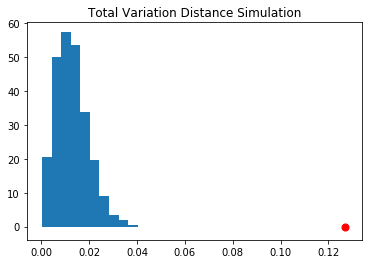

In [139]:
# Repeating simulation 5000 times and plotting results, comparing histogram to real value

tvds = np.array([])
repetitions = 5000
for i in range(repetitions):
    tvds = np.append(tvds, one_simulated_tvd())
plots.hist(tvds, density = True)
plots.scatter(real_value, 0, color='red', s=50)
plots.title("Total Variation Distance Simulation")
plots.show()

Clearly, the p-value is less than .05, so we can reject our null hypothesis. As a result, some configurations must be made to edit the function that calculates the difference between two teams.

In [140]:
interval_counts = matches.groupby("interval")["difference"].count()
# interval_counts

In [141]:
interval_list = matches.groupby("interval").median().index.get_level_values(0).tolist()

In [142]:
def home_probs_applied(row):
    interval = row["interval"]
    return prob_calculator(interval)[1]
def away_probs_applied(row):
    interval = row["interval"]
    return prob_calculator(interval)[2]
def draw_probs_applied(row):
    interval = row["interval"]
    return prob_calculator(interval)[3]

In [143]:
matches["home_odds"] = matches.apply(home_probs_applied, axis = 1)
matches["away_odds"] = matches.apply(away_probs_applied, axis = 1)
matches["draw_odds"] = matches.apply(draw_probs_applied, axis = 1)
matches

,Date,home,away,winner,fifa,difference,interval,home_odds,away_odds,draw_odds
0,17/08/2018,Real Betis,Levante UD,A,fifa_20,14.733333,10 to 15,0.562832,0.196460,0.240708
1,17/08/2018,Girona FC,Real Valladolid CF,D,fifa_20,-11.200000,-10 to -15,0.359292,0.339823,0.300885
2,18/08/2018,FC Barcelona,Deportivo Alavés,H,fifa_20,50.083333,50 to 55,0.776000,0.080000,0.144000
3,18/08/2018,RC Celta,RCD Espanyol,D,fifa_20,-3.250000,-1 to -5,0.432314,0.280932,0.286754
4,18/08/2018,Villarreal CF,Real Sociedad,A,fifa_20,5.500000,5 to 10,0.494382,0.219904,0.285714
...,...,...,...,...,...,...,...,...,...,...
375,11/05/14,Norwich City,Arsenal,A,fifa_15,-33.250000,-30 to -35,0.219814,0.532508,0.247678
376,11/05/14,Southampton,Manchester United,D,fifa_15,-27.550000,-25 to -30,0.248307,0.487585,0.264108
377,11/05/14,Sunderland,Swansea City,A,fifa_15,-11.300000,-10 to -15,0.359292,0.339823,0.300885
378,11/05/14,Tottenham Hotspur,Aston Villa,H,fifa_15,25.000000,25 to 30,0.679458,0.112867,0.207675
